## 1. The Actor and Critic network model

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        """ initialization """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        """ initialization """
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        #print ("xs shape {} action shape {} x shape {}". format(xs.shape, action.shape, x.shape))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


## 2. Replay buffer implementation

In [2]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        #self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## 3. Exploration noise

In [3]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## 4. Agent logic implementation

In [4]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DDPG_agent():
    def __init__(self, in_actor, in_critic, action_size, num_agents, random_seed):
        """init the agent"""
        #self.state_size = state_size
        self.action_size = action_size
        self.seed = random_seed
        
        # Construct Actor networks
        self.actor_local = Actor(in_actor, self.action_size, self.seed).to(device)
        self.actor_target = Actor(in_actor, self.action_size, self.seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        #print ("AGENTS {}".format(num_agents))
        # Construct Critic networks 
        self.critic_local = Critic(in_critic, num_agents*self.action_size, self.seed).to(device)
        self.critic_target = Critic(in_critic, num_agents*self.action_size, self.seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # noise processing
        self.noise = OUNoise((action_size), random_seed)
        
        # Replay memory
        #self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        #self.memory = MemoryBuffer(BUFFER_SIZE, BATCH_SIZE)
        
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        # convert state from numpy to pytorch array 
        state = torch.from_numpy(state).float().to(device)
        # use actor_local to predict action
        # turn nn into evaluation mode 
        self.actor_local.eval()
        # turn off computing gradients
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        # turn the nn into training mode
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        
        # clipping the action from min to max
        return np.clip(action, -1, 1)
    
    def target_act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        # convert state from numpy to pytorch array 
        #state = torch.from_numpy(state).float().to(device)
        action = self.actor_target(state)
        return action
        
    def reset(self):
        """ reset noise """
        self.noise.reset()
        

## 5. Initialize the Unity env

In [5]:
#install a few packages.  This line will take a few minutes to run!
!pip -q install ./python
!pip install unityagents
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis") #'Tennis_Windows_x86_64/Tennis.exe'

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 5. Initialize the Unity env

In [6]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


## 6. Run the training

In [7]:
class MADDPG:
    def __init__(self, in_actor, in_critic, action_size, num_agents, random_seed):
        self.agents = [DDPG_agent(in_actor, in_critic, action_size, num_agents, random_seed), 
                      DDPG_agent(in_actor, in_critic, action_size, num_agents, random_seed)]
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.num_agents = num_agents
        
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        actions = [agent.act(state, add_noise) for agent, state in zip(self.agents, states)]
        return actions
    
    def target_act(self, states):
        """Returns actions for given state as per current policy."""
        actions = [agent.target_act(state) for agent, state in zip(self.agents, states)]
        return actions
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #for i in range(state.shape[0]):
        state = np.asanyarray(state)
        action = np.asanyarray(action)
        reward = np.asanyarray(reward)
        next_state = np.asanyarray(next_state)
        done = np.asanyarray(done)
        self.memory.add(state.reshape((1, self.num_agents, -1)), action.reshape((1, self.num_agents, -1)), \
                        reward.reshape((1, self.num_agents, -1)), next_state.reshape((1,self.num_agents, -1)), \
                        done.reshape((1, self.num_agents, -1)))
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            for ai in range(self.num_agents):
                experiences = self.memory.sample()
                self.learn(experiences, ai, GAMMA)
    
    def reset(self):
        #print("Agents {}".format(self.agents[0]))
        #self.agents[0].reset()
        [agent.reset() for agent in self.agents]
        
    def learn(self, experiences, ai, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences

        agent = self.agents[ai]
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        
        next_states = next_states.view(1, BATCH_SIZE, self.num_agents, -1)
        actions_next = self.target_act(next_states)
        actions_next = torch.cat(actions_next, dim=1)
        next_states = next_states.view(BATCH_SIZE,-1)
        actions_next = actions_next.view(BATCH_SIZE,-1)
        #print (actions_next.shape)
        #print (next_states.shape)
        #print (next_states.shape)
        #print (actions_next.shape)
        #print( actions_next[0] )
        
        Q_targets_next = agent.critic_target(next_states, actions_next)
        #print (rewards[:,ai].shape)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards[:,ai] + (gamma * Q_targets_next * (1 - dones[:,ai]))
        # Compute critic loss
        Q_expected = agent.critic_local(states.view(BATCH_SIZE,-1), actions.view(BATCH_SIZE,-1))
        # mean squared error loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        # zero_grad because we do not want to accumulate 
        # gradients from other batches, so needs to be cleared
        agent.critic_optimizer.zero_grad()
        # compute derivatives for all variables that
        # requires_grad-True
        critic_loss.backward()
        # update those variables that requires_grad-True
        agent.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        # take the current states and predict actions
        #states = states.view(1, BATCH_SIZE, self.num_agents, -1)
        actions_pred = agent.actor_local(states)
        #print (actions_pred.shape)
        #actions_pred = torch.cat(actions_pred, dim=1)
        # -1 * (maximize) Q value for the current prediction
        actor_loss = -agent.critic_local(states.view(BATCH_SIZE,-1), actions_pred.view(BATCH_SIZE,-1)).mean()
        # Minimize the loss
        # zero_grad because we do not want to accumulate 
        # gradients from other batches, so needs to be cleared
        agent.actor_optimizer.zero_grad()
        # compute derivatives for all variables that
        # requires_grad-True
        actor_loss.backward()
        # update those variables that requires_grad-True
        agent.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(agent.critic_local, agent.critic_target, TAU)
        self.soft_update(agent.actor_local, agent.actor_target, TAU) 
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [8]:
#agents = DDPG_agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)
agents = MADDPG(in_actor=state_size, in_critic=state_size*num_agents, action_size=action_size, num_agents=num_agents, random_seed=0)
n_episodes = 10000
print_every = 10

In [9]:
import time
def ddpg(n_episodes=2000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agents.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agents.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                print('\tSteps: ', t)
                break 
        score = score[np.argmax(score)]
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.format(i_episode, 
                                                                          np.mean(scores_deque), 
                                                                          np.mean(score)))
        average_score = np.mean(scores_deque)
        if i_episode % print_every == 20 or average_score > 0.5:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
            torch.save(agents.agents[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agents.agents[0].critic_local.state_dict(), 'checkpoint_critic_0.pth') 
            torch.save(agents.agents[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agents.agents[1].critic_local.state_dict(), 'checkpoint_critic_1.pth') 
            if average_score > 0.5:
                break
    return scores
score = ddpg(n_episodes=n_episodes)

	Steps:  13
Episode 1	Average Score: 0.00	Score: 0.000
	Steps:  14
Episode 2	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 3	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 4	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 5	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 6	Average Score: 0.00	Score: 0.000
	Steps:  14
Episode 7	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 8	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 9	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 10	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 11	Average Score: 0.00	Score: 0.000
	Steps:  14
Episode 12	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 13	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 14	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 15	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 16	Average Score: 0.00	Score: 0.000
	Steps:  14
Episode 17	Average Score: 0.00	Score: 0.000
	Steps:  13
Episode 18	Average Score: 0.00	Score: 0.000
	

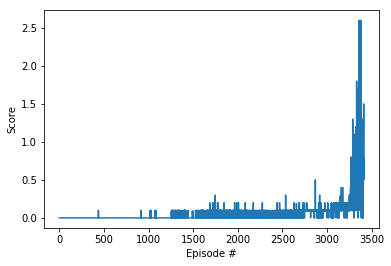

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score)+1), score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 7. Watch a smart agent

In [16]:
agents.agents[0].actor_local.load_state_dict(torch.load('checkpoint_actor_0.pth'))
agents.agents[0].critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth'))
agents.agents[1].actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agents.agents[1].critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
scores = np.zeros(num_agents)                          

while True:
    actions = agents.act(states, add_noise=False)                    
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    scores += rewards                         
    states = next_states                              
    if np.any(dones):
        print ("Final score {}".format(scores))
        break

Final score [ 0.80000001  0.79000001]


In [ ]:
env.close()